Frequency Analysis

In [1]:
import os, sys
sys.path.insert(1, os.getcwd()) 
sys.path.append("..")

In [2]:
from uilc.methods import pw
from uilc.utils.radiation import lambertian_convolve_1d

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

---
Start

In [12]:
#Optical system setting
cm = 1E-2
s = 50
alpha = 4 # W/H
W = 2*cm
H = W/alpha
nmax = pw.nmax(s, W, H)
print(nmax)

29


In [124]:
n = nmax-17
n_lim = nmax-17
n = n_lim + 7

In [143]:
n = 3*nmax

In [151]:
power_weight, pos, F = pw.power_weight(s, W, H, dim=n, set_nmax=False)
power_weight = power_weight/power_weight.max()
x, sig_low_f, sig_high_f = pw.get_signal_decomposition(n, s, W, H, ext_n=10, rate= 480)
sig_ext, pos_ext = pw.resample_n(pos, power_weight, 5, rate=240)
sig_low, sig_high = pw.signal_decomposition(pos_ext, sig_ext, 2*np.pi/W, return_type=True)
t_low, sig_low = pw.signal_cutting(pos_ext, sig_low, [-W/2-W/100 , W/2+W/100])


In [152]:
len(np.where(sig_high_f >sig_low_f[2:].max()*0.01)[0])

56

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


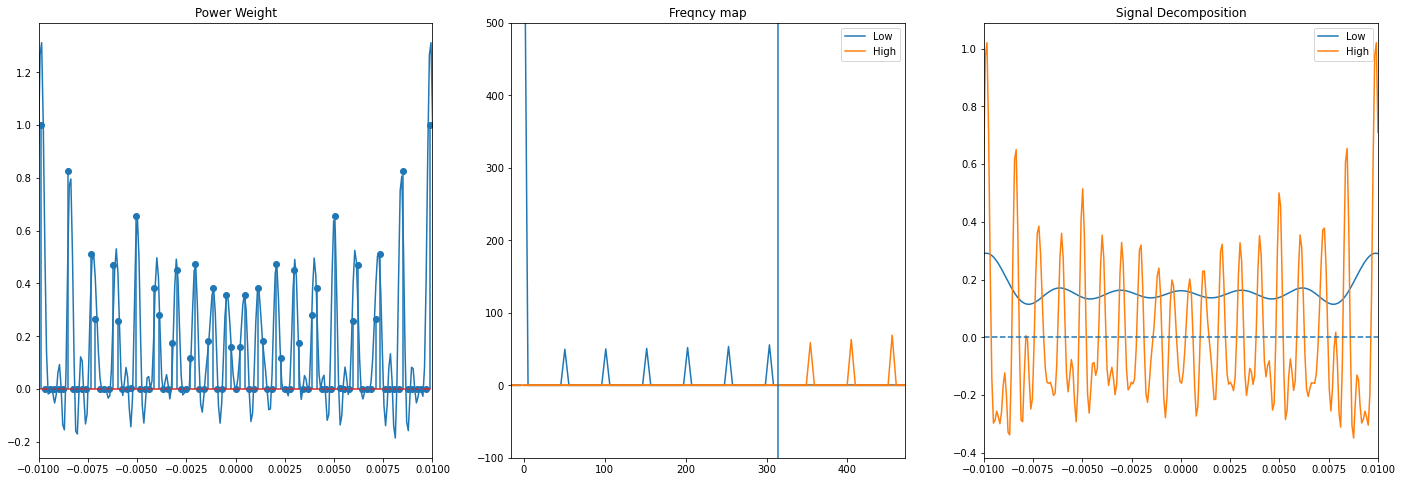

In [153]:
fig = plt.figure(figsize=(24,8))
axe_weight      = fig.add_subplot(1,3,1)
axe_frequency   = fig.add_subplot(1,3,2)
axe_resample    = fig.add_subplot(1,3,3)
#axe1
axe_weight.stem(pos, power_weight)
axe_weight.plot(pos_ext, sig_ext)
axe_weight.set_title("Power Weight")
axe_weight.set_xlim([-W/2, W/2])
#axe2
axe_frequency.plot(x, sig_low_f)
axe_frequency.plot(x, sig_high_f)
axe_frequency.legend(["Low", "High"])
axe_frequency .set_title("Freqncy map")
axe_frequency.axvline(x= 2*np.pi/W)
axe_frequency.set_xlim([-0.1*np.pi/W, 3*np.pi/W])
axe_frequency.set_ylim([-100, 500])
#axe3
axe_resample.plot(t_low, sig_low)
axe_resample.plot(pos_ext, sig_high)
axe_resample.legend(["Low", "High"])
axe_resample.set_title("Signal Decomposition")
axe_resample.set_xlim([-W/2, W/2])
axe_resample.axhline(y = 0, linestyle="--")

plt.show()


In [154]:
len(np.where(sig_high_f >0)[0])

2274

Find $n$ such that low frequencies are dominant in power weight.

In [155]:
index, _ = signal.find_peaks(sig_low)
sources_low = t_low[index]

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\scipy\signal\_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


In [156]:
sources_low

array([-9.84386973e-03, -6.13697318e-03, -3.08908046e-03,  4.11877395e-05,
        3.08908046e-03,  6.13697318e-03,  9.92624521e-03])

Mean, Max, Min/Max, std/Max
0.9692, 1.0000, 0.8633, 0.0339


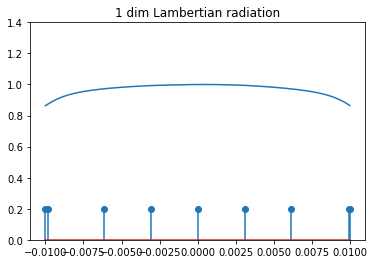

In [157]:
sources = np.append(sources_low, [-W/2, W/2])
plane_x = np.linspace(-W/2, W/2, 400, endpoint=True)
fig2 = plt.figure()
ax = fig2.add_subplot()
ax.stem(sources, np.zeros(len(sources))+0.2)
y_rad = lambertian_convolve_1d(plane_x, sources, s, H)
y_rad = y_rad/y_rad.max() 
ax.plot(plane_x, y_rad)
ax.set_ylim([0, 1.4])
ax.set_title("1 dim Lambertian radiation")
print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")

Great

---

$$\exists  f_{high},  ||f_{high}|| <2$$

Exists: only one or two
(peaks + 2) if n =4 then n=2

In [83]:

ax.stem(pos, power_weight/power_weight.max())
#ax.plot(pos_ext, sig_low.real/sig_low.max())
ax.plot(pos_ext, sig_high.real/sig_high.max())
#ax.plot(pos_ext, sig_ext/sig_ext.max())
ax.set_xlim([-W/2, W/2])
plt.show()

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


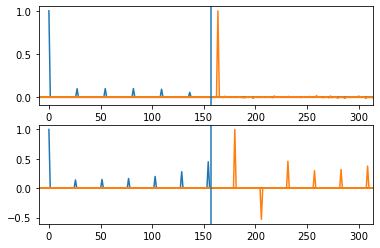

In [7]:
#ns = [nmax, int(1.5*nmax), int(3*nmax), int(4*nmax), int(6*nmax)]
ns  = [nmax, 3*nmax]
plot_data = [pw.get_signal_decomposition(n, s, W, H, ext_n=20, rate =240) for n in ns]
fig = plt.figure()
row = len(plot_data)
for i, (xf, sig_low, sig_high) in enumerate(plot_data):
    ax = fig.add_subplot(row, 1, i+1)
    ax.plot(xf, sig_low/sig_low.max())
    ax.plot(xf, sig_high/sig_high.max())
    ax.set_xlim([-10, 4*np.pi/(W)])
    ax.axvline(2*np.pi/W)
L = [1, 2, 3, 6]
#for n in L:
#    ax.axvline(2*np.pi/(n*W))

#ax.axvline(np.pi/W)
plt.show()

In [ ]:
n =ns[0]
sig, time, F =pw.power_weight(s, W, H, dim=n set_nmax=False)
sig_low, sig_high = pw.signal_decomposition(time, sig, 2*np.pi/W)

(-0.02, 0.02)

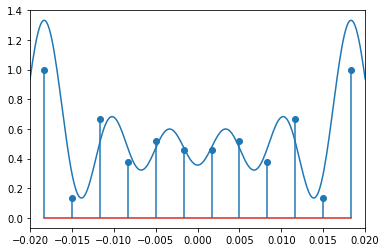

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pos_ext, sig_ext)
ax.stem(xarr, yarr)
ax.set_xlim([-W/2, W/2])

In [ ]:
si_low, si_high = pw.signal_decomposition(sig_ext, pos_ext, 2*np.pi/W)

In [18]:
delta, pos, K = pw.power_weight(s, W, H, dim = int(2*nmax), set_nmax=False)
si, t = pw.resample_n(delta, pos, 6)
si_low, si_high = pw.signal_decomposition(si, t, 2*np.pi/W)
si_low = si_low.real
si_high = si_high.real
index, _ = signal.find_peaks(si_low)


(-0.02, 0.02)

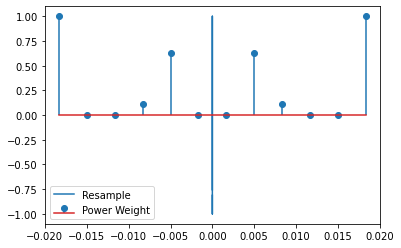

In [19]:
fig = plt.figure()
ax = fig.add_subplot()

#dt = 2.5*(t[1]-t[0])
#t += dt

mark_text = []
ax.plot(t, si/si.max())
mark_text.append("Resample")
#ax.plot(t, si_low/si_low.max())
#mark_text.append("Low Frequency")
#ax.plot(t, si_high/si_high.max())
#mark_text.append("High Frequency")

for i in index:
    ax.axvline(x=t[i])
ax.stem(pos, delta/delta.max())
mark_text.append("Power Weight")

ax.legend(mark_text)
ax.set_xlim([-W/2, W/2])


(-0.02, 0.02)

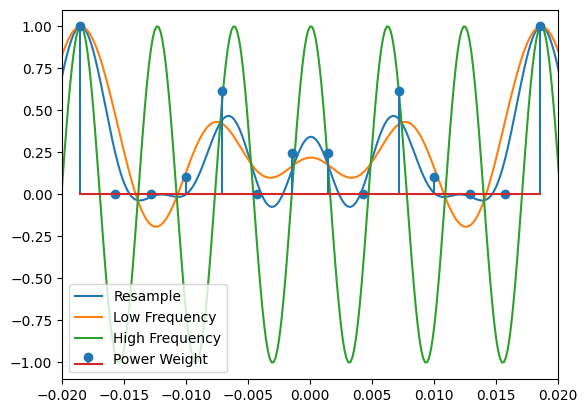

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

#dt = 2.5*(t[1]-t[0])
#t += dt

mark_text = []
#t_p = t-center_shifted
ax.plot(t, si/si.max())
mark_text.append("Resample")
ax.plot(t, si_low/si_low.max())
mark_text.append("Low Frequency")
ax.plot(t, si_high/si_high.max())
mark_text.append("High Frequency")

#for i in index:
#    ax.axvline(x=t[i])
ax.stem(pos, delta/delta.max())
mark_text.append("Power Weight")

ax.legend(mark_text)
ax.set_xlim([-W/2, W/2])


In [10]:
from scipy.signal import find_peaks

In [11]:
t_in = np.where(t <W/2)
t_sample = t[t_in]
sig_low = si_low[t_in]
sig_high = si_high[t_in]

t_in2 = np.where(-W/2< t_sample)
t_sample = t_sample[t_in2]
sig_low = sig_low[t_in2]
sig_high = sig_high[t_in2]

In [12]:
index_s_low = find_peaks(sig_low)[0]
index_s_high = find_peaks(sig_high)[0]

In [13]:
index_s_low

array([  9,  80, 129, 179, 249], dtype=int64)

In [14]:
s_arr_low = t_sample[index_s_low]
s_arr_high = t_sample[index_s_high]

In [15]:
from uilc.radiation import lambertian_1d

In [16]:
source = s_arr_low - (s_arr_low.max() + s_arr_low.min())/2

In [26]:
arr = s_arr_low - (s_arr_low.max() + s_arr_low.min())/2

In [45]:
# low frequncy result
source = np.append(arr, [-W/2, W/2])
#source =s_arr_low
xarr = np.linspace(-W/2, W/2, 400, endpoint=True)

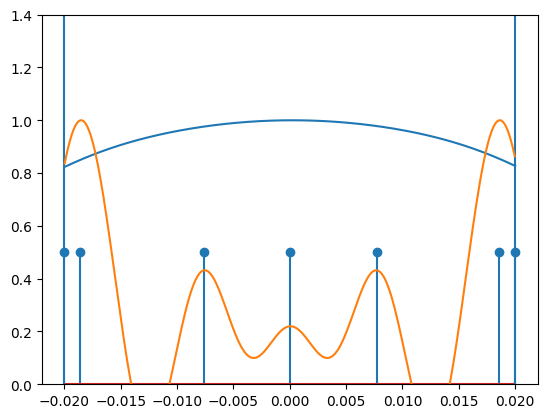

Mean, Max, Min/Max, std/Max
0.9448, 1.0000, 0.8227, 0.0512


In [46]:
y_rad = lambertian_1d(xarr, source, s, W, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.plot(t_sample, sig_low/sig_low.max())
ax.set_ylim([0, 1.4])
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


In [47]:
# High frequncy result
source = np.append(s_arr_high, [-W/2, W/2])

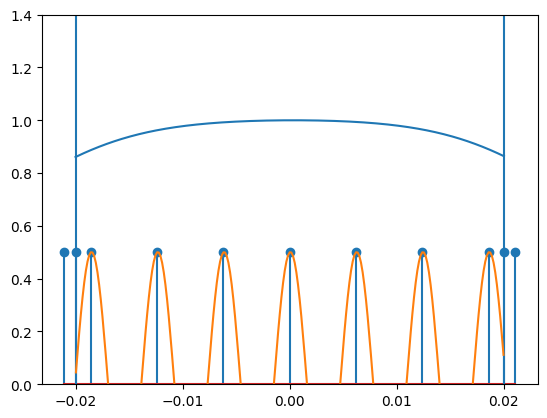

Mean, Max, Min/Max, std/Max
0.9630, 1.0000, 0.8609, 0.0391


In [44]:
y_rad = lambertian_1d(xarr, source, s, W, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.plot(t_sample, 0.5*sig_high/sig_high.max())
ax.set_ylim([0, 1.4])
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


In [35]:
s_arr_high[4] = 0
s_arr_high[7] = 0

In [52]:
source = np.append(s_arr_low, [-W/2, W/2])

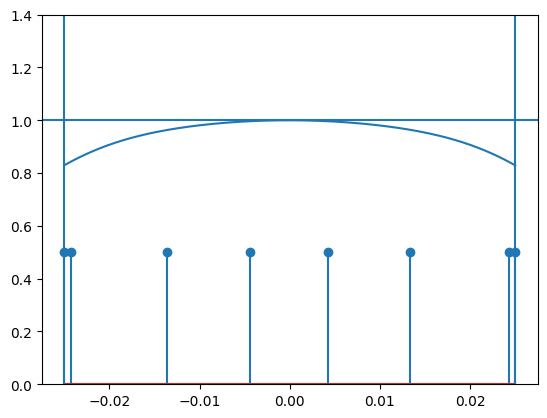

Mean, Max, Min/Max, std/Max
0.9516, 1.0000, 0.8294, 0.0481


In [55]:
y_rad = lambertian_1d(xarr, source, s, W, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.set_ylim([0, 1.4])
ax.axhline(y = 1)
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


---

Power weight map with number calculation.

1. Calculate power weight.
2. Normalization, Extending, Resampling.
3. Applying Low/high pass filter with band: $f_b = \frac{2 \pi}{W}$.


### Power weighting

$n$: number of the peaks after (3), 
${w_i}_{i=1}^n$: peak values.

Source location = peak location

### Distribution

Decompose into 


